<a href="https://colab.research.google.com/github/carolquaggio/Hydrologic_station_data_view/blob/main/DataPaper_for_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

> Start by making a copy of this Colab file in your Google Drive. Then, upload the Rain_data.csv and Streamflow_data.csv files to your Google Drive account, under 'My Drive'.

> Run the code in the order provided and illustrated in the flowchart below.

> The code is divided into sections, each of which is preceded by a brief description of the action it performs.

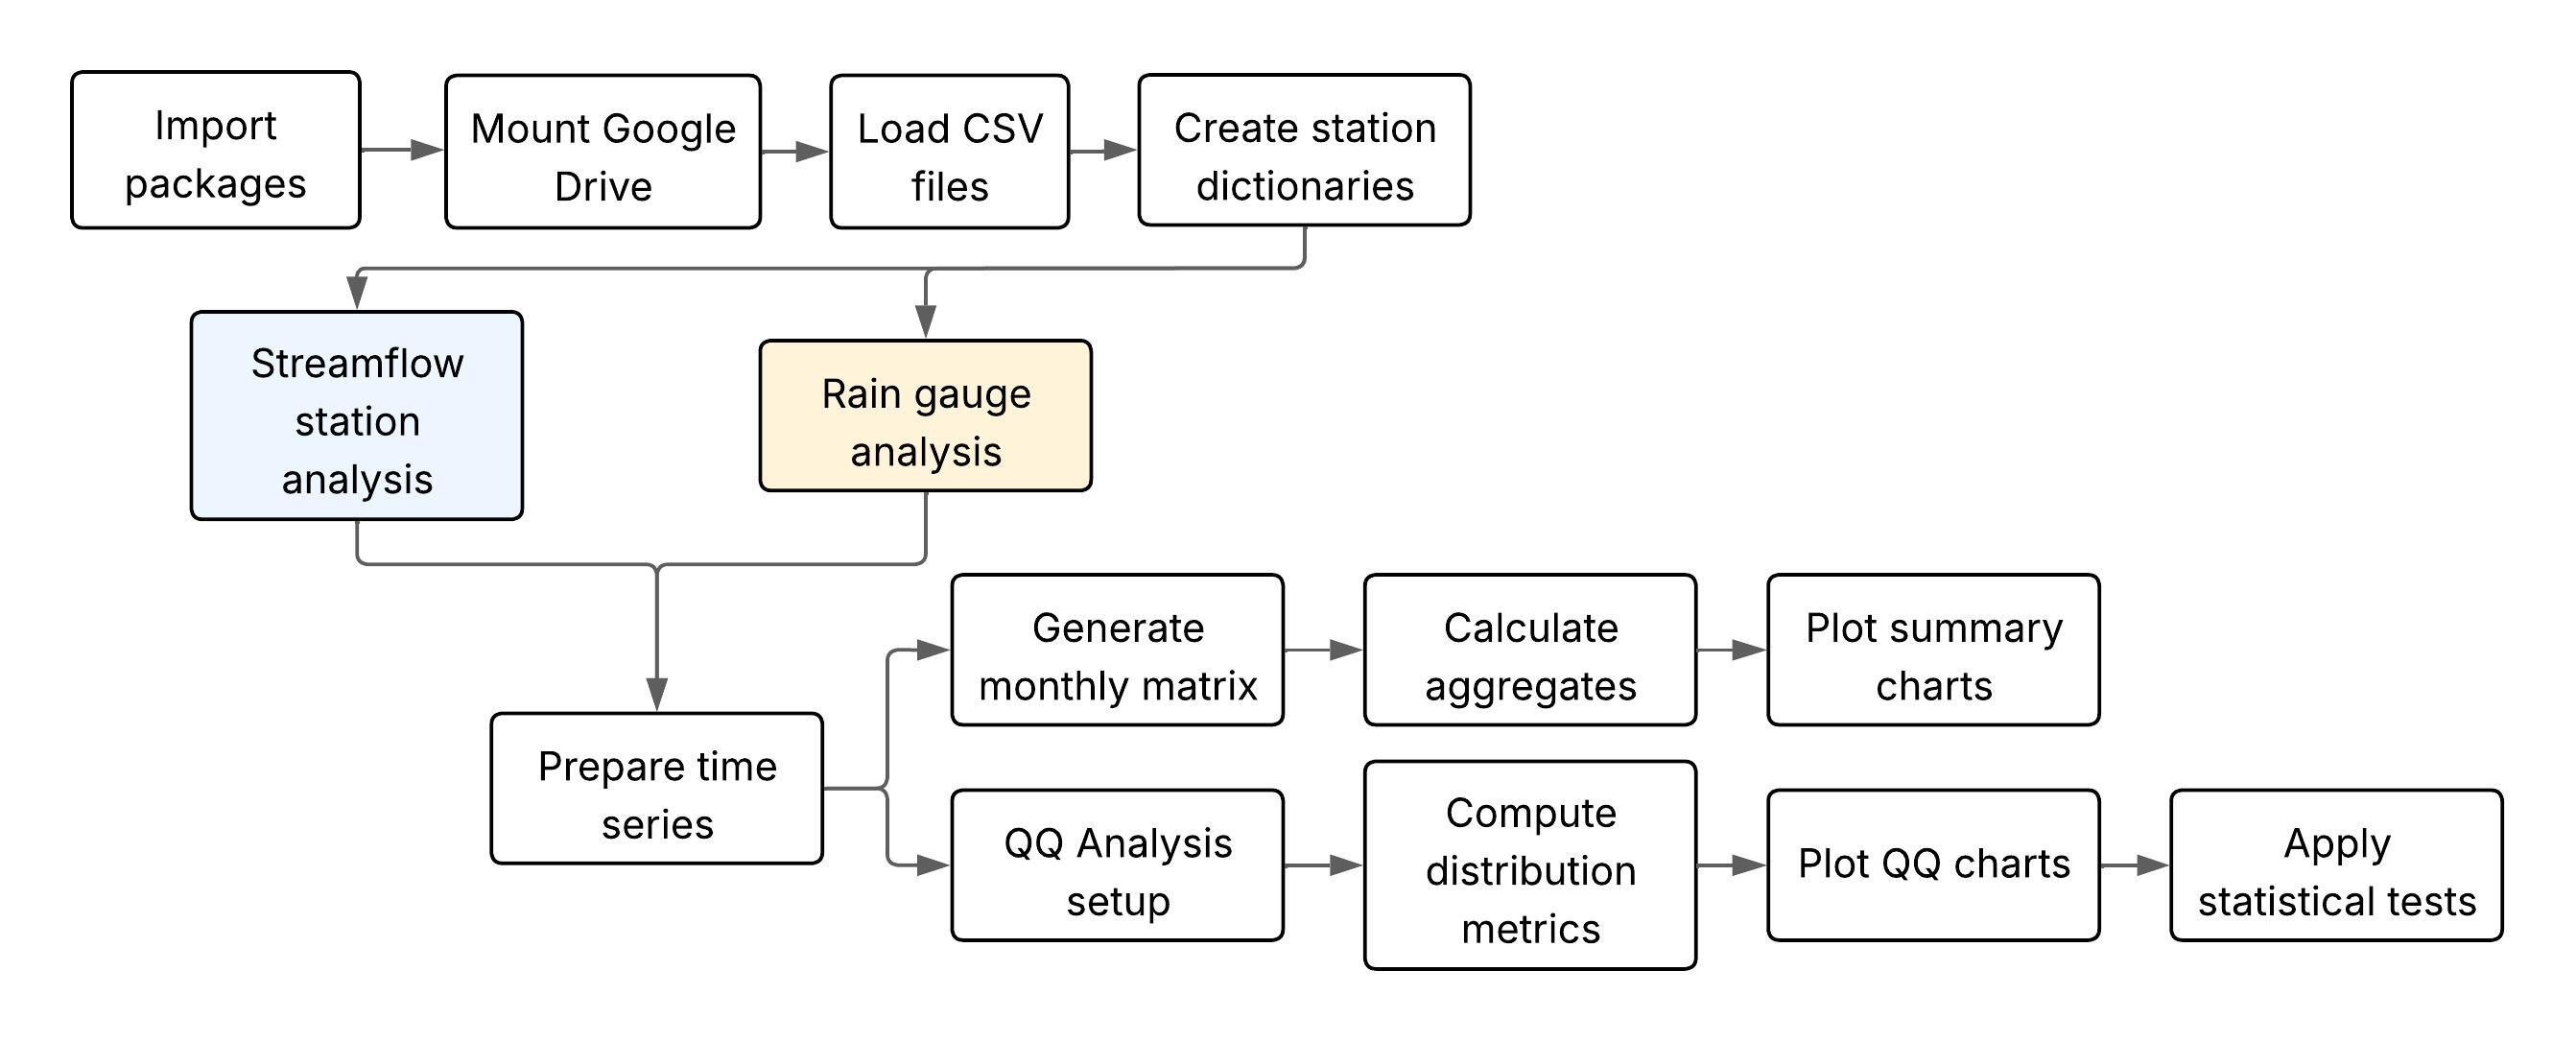

In [1]:
# ------------------------------------------------------------------------------
# Import the packages that will be used
# ------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import kruskal

!pip install pymannkendall
import pymannkendall as mk
#Reference: Hussain et al., (2019). pyMannKendall: https://doi.org/10.21105/joss.01556


# ------------------------------------------------------------------------------
# This will connect to your Google Drive and import the files
# ------------------------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/'
pluvio = pd.read_csv(path+'Rain_data.csv', sep=';')
fluvio = pd.read_csv(path+'Streamflow_data.csv', sep=';')


Mounted at /content/drive


In [2]:
# ------------------------------------------------------------------------------
# Create a dictionary of stations
# ------------------------------------------------------------------------------

Rain_Gauges = {
    station_name: group.reset_index(drop=True)
    for station_name, group in pluvio.groupby("Station")
}

Streamflow_Stations = {
    station_name: group.reset_index(drop=True)
    for station_name, group in fluvio.groupby("Station")
}

In [4]:
# ------------------------------------------------------------------------------
# List the names of the available stations
# ------------------------------------------------------------------------------

print(list(Rain_Gauges.keys()))

print(list(Streamflow_Stations.keys()))

['P001', 'P002', 'P003', 'P004', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014', 'P015', 'P016', 'P017', 'P018', 'P019', 'P020', 'P021', 'P022', 'P023', 'P024', 'P025', 'P026', 'P027', 'P028', 'P029', 'P030', 'P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039', 'P040', 'P041', 'P042', 'P043', 'P044', 'P045', 'P046', 'P047', 'P048', 'P049', 'P050', 'P051', 'P052', 'P053', 'P054', 'P055', 'P056', 'P057', 'P058', 'P059', 'P060', 'P061', 'P062', 'P063', 'P064', 'P065', 'P066', 'P067', 'P068', 'P069', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076', 'P077', 'P078', 'P079', 'P080', 'P081', 'P082', 'P083', 'P084', 'P085', 'P086', 'P087', 'P088', 'P089', 'P090', 'P091', 'P092', 'P093', 'P094', 'P095', 'P096', 'P097', 'P098', 'P099', 'P100', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P110']
['F007', 'F009', 'F010', 'F011', 'F012', 'F013', 'F014', 'F015', 'F016', 'F017', 'F019', 'F020', 'F021', 'F023', 'F025', 'F026', 'F028'

In [5]:
# Are named as: PXXX, wheres XXX range from 001 to 110
Rain_Gauges['P001'].head()

,Station,Station_Code,Date,Rainfall_mm
0,P001,2047018,1937-08-01,0.0
1,P001,2047018,1937-08-02,0.0
2,P001,2047018,1937-08-03,0.0
3,P001,2047018,1937-08-04,0.0
4,P001,2047018,1937-08-05,0.0


In [6]:
# Are named as: F0XX, wheres XX range from 001 to 38
Streamflow_Stations['F007'].head()

,Station,Station_Code,Date,Streamflow_m3_s,Streamflow_mm_day
0,F007,61783450,2012-09-01,27.5824,0.513603
1,F007,61783450,2012-09-02,26.9960,0.502684
2,F007,61783450,2012-09-03,28.1717,0.524576
3,F007,61783450,2012-09-04,22.9753,0.427816
4,F007,61783450,2012-09-05,26.9960,0.502684


# Rainfall plots

>  The first plot provides an overview of daily, monthly, and annual data.

In [ ]:
# ------------------------------------------------------------------------------
# Create a function that defines the plot aspects
# ------------------------------------------------------------------------------

def plot_rain(Rain_Gauges, station):
    # --- prepare the DataFrame ---
    P_df = Rain_Gauges[station].copy()
    P_df = P_df[P_df['Rainfall_mm'] <= 1000].copy()
    P_df["Date"] = pd.to_datetime(P_df["Date"])
    P_df["month"] = P_df["Date"].dt.month
    P_df["year"] = P_df["Date"].dt.year
    P_df["day"] = P_df["Date"].dt.day

    # --- Monthly rainfall matrix ---
    P_matriz = pd.DataFrame(index=range(1, 13), columns=range(1930, 2024))
    for year in range(1930, 2024):
        for month in range(1, 13):
            soma_month = P_df.loc[(P_df['month'] == month) & (P_df['year'] == year), 'Rainfall_mm'].sum()
            if soma_month > 0:
                P_matriz.at[month, year] = soma_month
            else:
                P_matriz.at[month, year] = None

    # --- Totals and means ---
    months = list(range(1, 13))
    mean_month = [P_matriz.loc[month].mean() for month in months]
    years = list(P_matriz.columns)
    sum_years = [P_matriz[year].sum() for year in years]

    # --- Remove zeros for daily plot ---
    no_zero = P_df[P_df["Rainfall_mm"] > 0]

    # --- Plot ---
    fig, axs = plt.subplots(3, 1, figsize=(12, 11))

    # Anual
    axs[0].bar(years, sum_years, width=0.6, align='center', alpha=0.7, color='mediumslateblue')
    axs[0].set_xlabel("Year", fontweight="bold")
    axs[0].set_ylabel("Accumulated Rainfall (mm/year)", fontweight="bold")
    axs[0].set_title(f"{station} – Rain Gauge Summary", fontweight="bold")
    for linha in [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]:
        axs[0].axvline(x=linha, color='black', linestyle='--')
    axs[0].grid(axis='y', color='lightgrey', linewidth=0.5)

    # Mensal
    axs[1].bar(months, mean_month, width=0.6, align='center', alpha=0.7, color='blue')
    axs[1].set_xlabel("Month", fontweight="bold")
    axs[1].set_xticks(months)
    axs[1].set_ylabel("Mean Rainfall (mm/month)", fontweight="bold")
    axs[1].grid(axis='y', color='lightgrey', linewidth=0.5)

    # Diário
    axs[2].plot(no_zero['Date'], no_zero['Rainfall_mm'], color='darkblue')
    axs[2].set_xlabel("Date", fontweight="bold")
    axs[2].set_ylabel("Daily Rainfall (mm)", fontweight="bold")
    axs[2].grid(axis='y', color='lightgrey', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f'{station}.svg', format='svg') #vector file
    plt.savefig(f'{station}.jpg', format='jpg')
    plt.show()

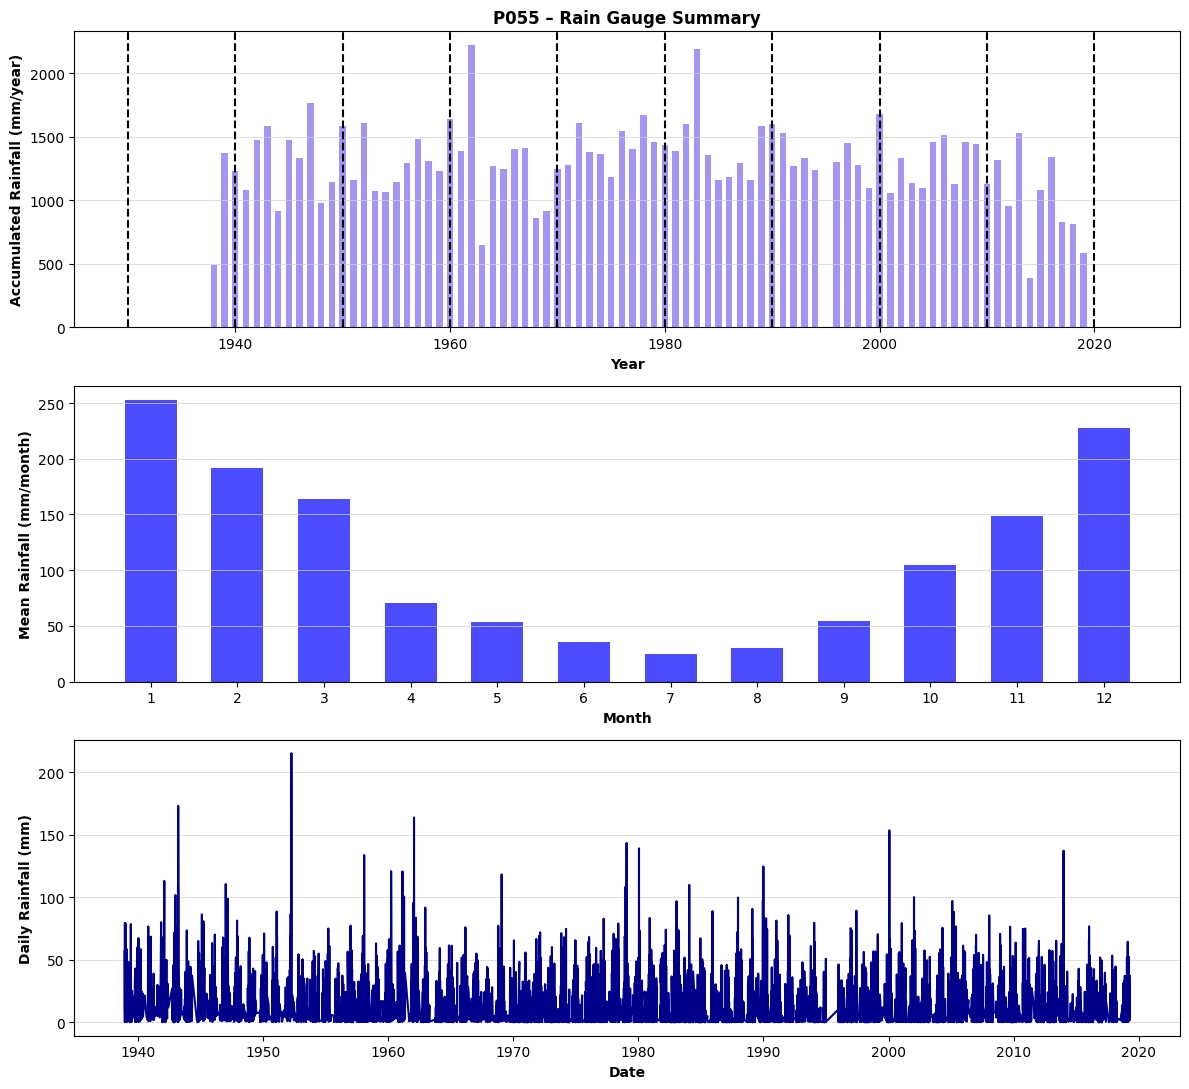

In [ ]:
# ------------------------------------------------------------------------------
# Choose and plot the station
# ------------------------------------------------------------------------------

plot_rain(Rain_Gauges, 'P055')


> The second plot provides a statistical overview that includes a Q-Q plot of daily, monthly, and annual data with annotated statistical parameters, as well as an annual cumulative frequency (ACF) plot.

In [ ]:
def plot_QQ_summary(Rain_Gauges, station):
    df = Rain_Gauges[station].copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df["month"] = df["Date"].dt.month
    df["year"] = df["Date"].dt.year

    # ----- Daily -----
    daily_data = df["Rainfall_mm"].dropna()
    daily_data = daily_data[daily_data > 0]

    # ----- Montlhy -----
    monthly_data = df.groupby(["year", "month"])["Rainfall_mm"].sum().reset_index()
    monthly_vals = monthly_data["Rainfall_mm"].dropna()

    # ----- Annual -----
    annual_data = df.groupby("year")["Rainfall_mm"].sum().reset_index()
    annual_vals = annual_data["Rainfall_mm"].dropna()

    # ----- ACF -----
    P_cdf = annual_data.copy()
    P_cdf = P_cdf.sort_values(by="Rainfall_mm").reset_index(drop=True)
    P_cdf['m'] = range(1, len(P_cdf) + 1)
    P_cdf['m/N'] = P_cdf['m'] / len(P_cdf)

    # ----- QQ-plot helper -----
    def qq_plot(ax, dados, titulo, use_seasonal=False):
        quant_teoricos = np.random.normal(0, 1, len(dados))
        dados_ord = np.sort(dados)
        count = len(dados_ord)
        mean = np.mean(dados_ord)
        std = np.std(dados_ord)
        teor_ord = np.sort(quant_teoricos)
        m, b = np.polyfit(teor_ord, dados_ord, 1)
        ax.scatter(teor_ord, dados_ord, color='cornflowerblue', s=12)
        ax.plot(teor_ord, m * teor_ord + b, color='grey', linestyle='--', label=f'Linear fit: y={m:.1f}x+{b:.1f}')

        #Shapiro Wiki
        stat, pval = stats.shapiro(dados_ord)
        normal = 'Normal' if pval > 0.05 else 'Not normal'

        # Mann-Kendall: seasonal if true
        if use_seasonal:
           resultado = mk.seasonal_test(dados_ord)
        else:
            resultado = mk.original_test(dados_ord)

        # unpack resultado
        trend = resultado.trend
        pval_mk = resultado.p
        slope = resultado.slope

        ax.set_title(titulo, fontweight='bold')
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Observed")
        ax.set_ylim(0,)
        ax.text(0.05, 0.95, f'SW p = {pval:.1e} ({normal})', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.9, f'MK p = {pval_mk:.1e}, Trend = {trend}', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.85, f'Slope = {slope:.2f}', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.75, f'Count = {count:.0f}', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.7, f'Mean = {mean:.1f} +/- {std:.2f}', transform=ax.transAxes, fontsize=9)
        ax.legend()

    # ----- CDF plot -----
    def plot_cdf(ax):
        ax.plot(P_cdf['m/N'], P_cdf['Rainfall_mm'], marker='o', linestyle='-', color='mediumslateblue')
        ax.set_xlabel("Cumulative Relative Frequency")
        ax.set_ylabel("Annual Rainfall (mm)")
        ax.set_title("Annual Cumulative Frequency", fontweight="bold")
        m, b = np.polyfit(P_cdf['m/N'], P_cdf['Rainfall_mm'], 1)
        ax.plot(P_cdf['m/N'], m * P_cdf['m/N'] + b, color='grey', linestyle='--', label=f'Linear fit: y={m:.1f}x+{b:.1f}')
        ax.grid(True, linestyle=':', color='lightgrey')
        ax.legend()

    # ----- Plot Layout -----
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    qq_plot(axs[0, 0], daily_data, "Daily / Original MK")
    qq_plot(axs[0, 1], monthly_vals, "Monthly / Seasonal MK", use_seasonal=True)
    qq_plot(axs[1, 0], annual_vals, "Annual / Original MK")
    plot_cdf(axs[1, 1])

    fig.suptitle(f"{station} – Rain Gauge Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{station}_stats.svg', format='svg') #vector file
    plt.savefig(f'{station}_stats.jpg', format='jpg')
    plt.show()


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8273.
  res = hypotest_fun_out(*samples, **kwds)


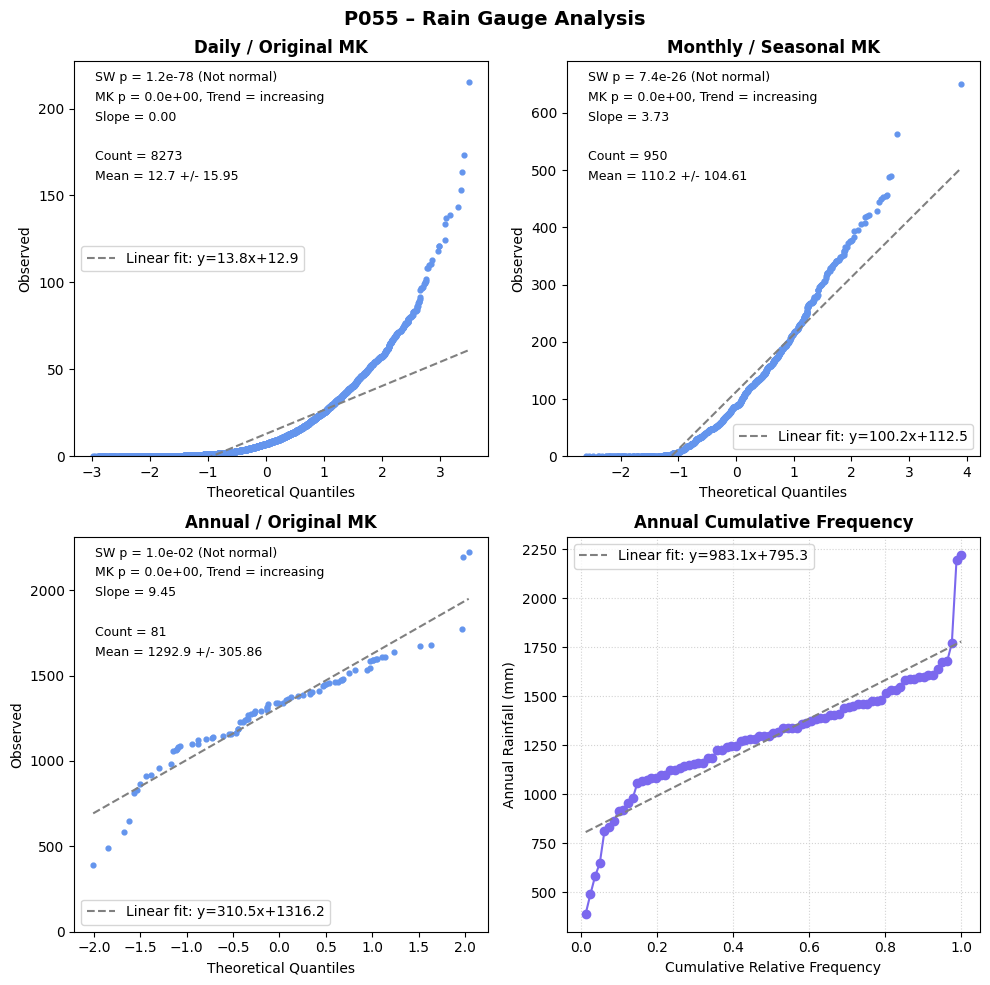

In [ ]:
# ------------------------------------------------------------------------------
# Choose and plot the station
# ------------------------------------------------------------------------------

plot_QQ_summary(Rain_Gauges, 'P055')


# Streamflow plots

>  The first plot provides an overview of daily, monthly, and annual data.

In [ ]:
# ------------------------------------------------------------------------------
# Create a function that defines the plot aspects
# ------------------------------------------------------------------------------

def plot_streamflow(Streamflow_Stations, station):
    # --- prepare the DataFrame ---
    P_df = Streamflow_Stations[station].copy()
    P_df["Date"] = pd.to_datetime(P_df["Date"])
    P_df["month"] = P_df["Date"].dt.month
    P_df["year"] = P_df["Date"].dt.year
    P_df["day"] = P_df["Date"].dt.day

    # --- Monthly matrix ---
    P_matriz = pd.DataFrame(index=range(1, 13), columns=range(1930, 2024))
    for year in range(1930, 2024):
        for month in range(1, 13):
            soma_month = P_df.loc[(P_df['month'] == month) & (P_df['year'] == year), 'Streamflow_mm_day'].sum()
            if soma_month > 0:
                P_matriz.at[month, year] = soma_month
            else:
                P_matriz.at[month, year] = None

    # --- Totals and means ---
    months = list(range(1, 13))
    mean_month = [P_matriz.loc[month].mean() for month in months]
    years = list(P_matriz.columns)
    sum_years = [P_matriz[year].sum() for year in years]

    # --- Remove zeros for daily plot ---
    no_zero = P_df[P_df["Streamflow_mm_day"] > 0]

    # --- Plot ---
    fig, axs = plt.subplots(3, 1, figsize=(12, 11))

    # Anual
    axs[0].bar(years, sum_years, width=0.6, align='center', alpha=0.7, color='lightgreen')
    axs[0].set_xlabel("Year", fontweight="bold")
    axs[0].set_ylabel("Accumulated Streamflow (mmm/year)", fontweight="bold")
    axs[0].set_title(f"{station} – Streamflow Station Summary", fontweight="bold")
    for linha in [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]:
        axs[0].axvline(x=linha, color='black', linestyle='--')
    axs[0].grid(axis='y', color='lightgrey', linewidth=0.5)

    # Mensal
    axs[1].bar(months, mean_month, width=0.6, align='center', alpha=0.7, color='mediumseagreen')
    axs[1].set_xlabel("Month", fontweight="bold")
    axs[1].set_xticks(months)
    axs[1].set_ylabel("Mean Streamflow (mm/month)", fontweight="bold")
    axs[1].grid(axis='y', color='lightgrey', linewidth=0.5)

    # Diário
    axs[2].plot(no_zero['Date'], no_zero['Streamflow_mm_day'], color='darkgreen')
    axs[2].set_xlabel("Date", fontweight="bold")
    axs[2].set_ylabel("Daily Streamflow (mm/day)", fontweight="bold")
    axs[2].grid(axis='y', color='lightgrey', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f'{station}.svg', format='svg') #vector file
    plt.savefig(f'{station}.jpg', format='jpg')
    plt.show()

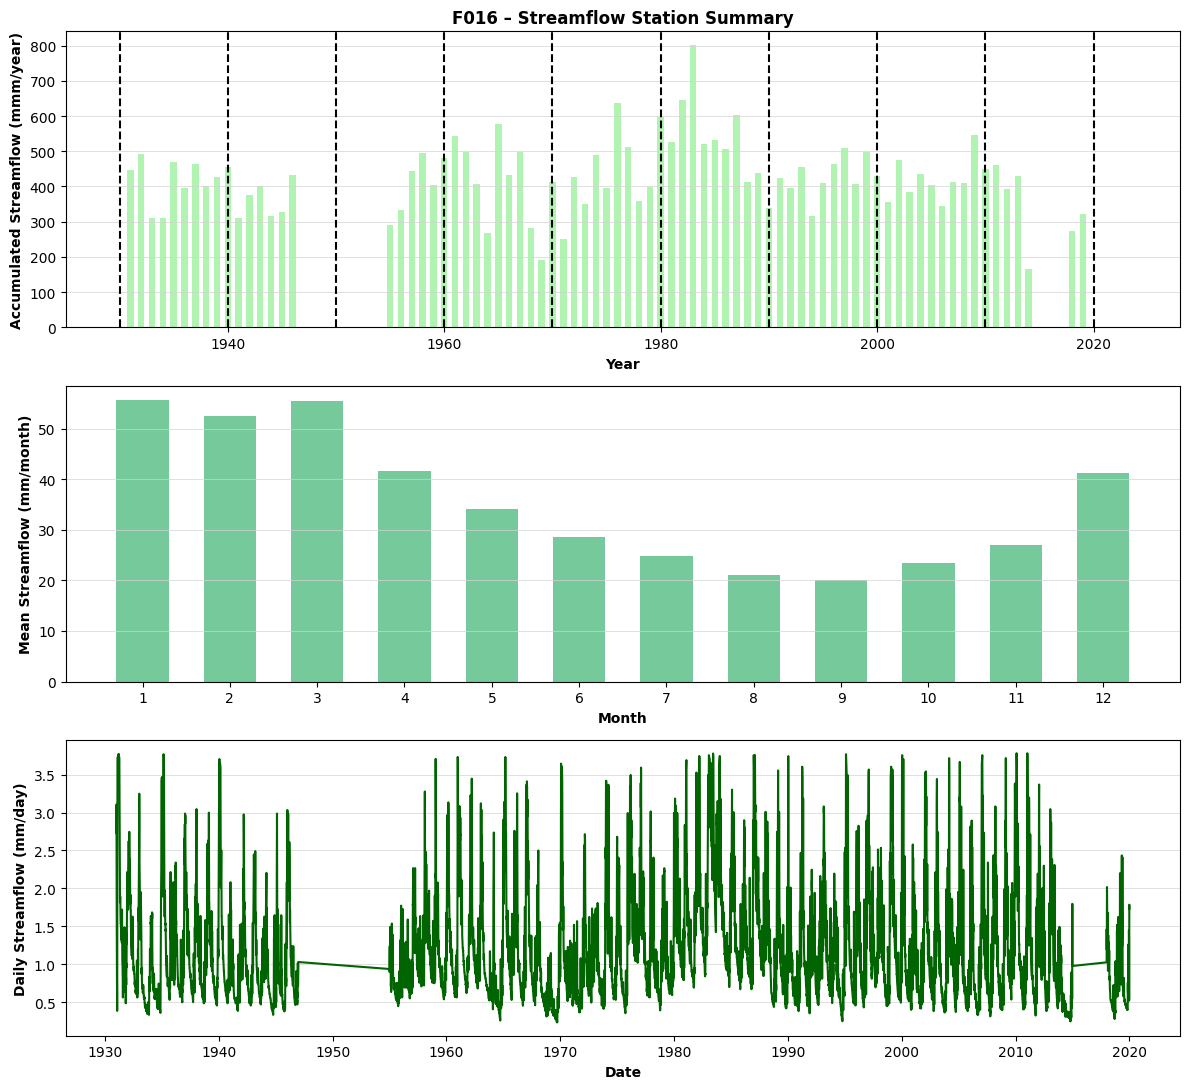

In [ ]:
# ------------------------------------------------------------------------------
# Choose and plot the station
# ------------------------------------------------------------------------------

plot_streamflow(Streamflow_Stations, 'F016')


> The second plot provides a statistical overview that includes a Q-Q plot of daily, monthly, and annual data with annotated statistical parameters, as well as an annual cumulative frequency (ACF) plot.

In [ ]:
def plot_QQ_summary_SF(Streamflow_Stations, station):
    df = Streamflow_Stations[station].copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df["month"] = df["Date"].dt.month
    df["year"] = df["Date"].dt.year

    # ----- Daily -----
    daily_data = df["Streamflow_mm_day"].dropna()
    daily_data = daily_data[daily_data > 0]

    # ----- Montlhy -----
    monthly_data = df.groupby(["year", "month"])["Streamflow_mm_day"].sum().reset_index()
    monthly_vals = monthly_data["Streamflow_mm_day"].dropna()

    # ----- Annual -----
    annual_data = df.groupby("year")["Streamflow_mm_day"].sum().reset_index()
    annual_vals = annual_data["Streamflow_mm_day"].dropna()

    # ----- ACF -----
    P_cdf = annual_data.copy()
    P_cdf = P_cdf.sort_values(by="Streamflow_mm_day").reset_index(drop=True)
    P_cdf['m'] = range(1, len(P_cdf) + 1)
    P_cdf['m/N'] = P_cdf['m'] / len(P_cdf)

    # ----- QQ-plot helper -----
    def qq_plot(ax, dados, titulo, use_seasonal=False):
        quant_teoricos = np.random.normal(0, 1, len(dados))
        dados_ord = np.sort(dados)
        count = len(dados_ord)
        mean = np.mean(dados_ord)
        std = np.std(dados_ord)
        teor_ord = np.sort(quant_teoricos)
        m, b = np.polyfit(teor_ord, dados_ord, 1)

        ax.scatter(teor_ord, dados_ord, color='mediumseagreen', s=12)
        ax.plot(teor_ord, m * teor_ord + b, color='grey', linestyle='--', label=f'Linear fit: y={m:.1f}x+{b:.1f}')

        #Shapiro Wiki
        stat, pval_sw = stats.shapiro(dados_ord)
        normal = 'Normal' if pval_sw > 0.05 else 'Not normal'

        # Mann-Kendall: seasonal if true
        if use_seasonal:
           resultado = mk.seasonal_test(dados_ord)
        else:
            resultado = mk.original_test(dados_ord)

        # unpack resultado
        trend = resultado.trend
        pval_mk = resultado.p
        slope = resultado.slope

        # Plots with annotated values
        ax.set_title(titulo, fontweight='bold')
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Observed")
        ax.set_ylim(0,)
        ax.text(0.05, 0.95, f'SW p = {pval_sw:.1e} ({normal})', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.9, f'MK p = {pval_mk:.1e}, Trend = {trend}', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.85, f'Slope = {slope:.2f}', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.75, f'Count = {count:.0f}', transform=ax.transAxes, fontsize=9)
        ax.text(0.05, 0.7, f'Mean = {mean:.1f} +/- {std:.2f}', transform=ax.transAxes, fontsize=9)
        ax.legend()

    # ----- CDF plot -----
    def plot_cdf(ax):
        ax.plot(P_cdf['m/N'], P_cdf['Streamflow_mm_day'], marker='o', linestyle='-', color='green')
        ax.set_xlabel("Cumulative Relative Frequency")
        ax.set_ylabel("Accumulated Streamflow (mm/year)")
        ax.set_title("Annual Cumulative Frequency", fontweight="bold")
        m, b = np.polyfit(P_cdf['m/N'], P_cdf['Streamflow_mm_day'], 1)
        ax.plot(P_cdf['m/N'], m * P_cdf['m/N'] + b, color='grey', linestyle='--', label=f'Linear fit: y={m:.1f}x+{b:.1f}')
        ax.grid(True, linestyle=':', color='lightgrey')
        ax.legend()

    # ----- Plot Layout -----
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    qq_plot(axs[0, 0], daily_data, "Daily / Original MK")
    qq_plot(axs[0, 1], monthly_vals, "Monthly / Seasonal MK", use_seasonal=True)
    qq_plot(axs[1, 0], annual_vals, "Annual / Original MK")
    plot_cdf(axs[1, 1])

    fig.suptitle(f"{station} – Streamflow Station Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{station}_stats.svg', format='svg') #vector file
    plt.savefig(f'{station}_stats.jpg', format='jpg')
    plt.show()


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28205.
  res = hypotest_fun_out(*samples, **kwds)


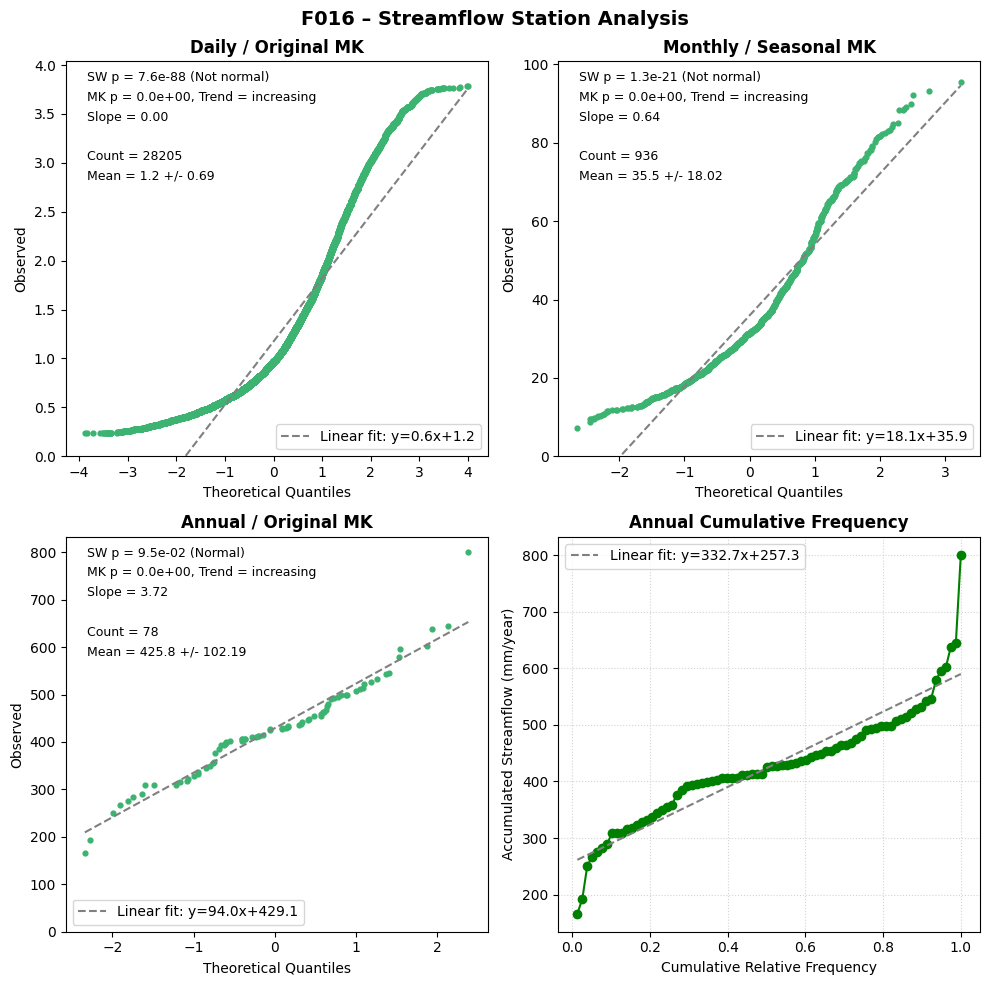

In [ ]:
# ------------------------------------------------------------------------------
# Choose and plot the station
# ------------------------------------------------------------------------------

plot_QQ_summary_SF(Streamflow_Stations, 'F016')
